# Tomographic Reconstruction: Total Variation regularization

Description: implementing  Total Variation (TV) regularized tomographic reconstruction using an ISTA-like optimization algorithm. It also mentions a comparison with a deep-learning-based unrolling method, for which external reconstructions are provided.

## Section 1: Import Libraries

  Code Comment: This cell imports necessary Python libraries for numerical operations (NumPy), plotting (Matplotlib), file system operations (os), data manipulation (Pandas), and various image processing tasks from scikit-image, including Radon and inverse Radon transforms, resizing, phantom generation, and image quality metrics (PSNR, SSIM), as well as TV denoising.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_tv_chambolle
from PIL import Image

## Section 2: Helper functons

   Description: This section defines several helper functions that will be used throughout the notebook for tasks like error calculation, sinogram generation, and image reconstruction.

In [ ]:
def relative_error(true, pred):

  """
  Calculates the Frobenius norm of the difference between the true and predicted images,
  normalized by the Frobenius norm of the true image.
  This gives a measure of the relative reconstruction error.
  """

  return np.linalg.norm(true - pred, 'fro') / np.linalg.norm(true, 'fro')


def generate_limited_angle_sinogram(image, num_angles, angle_range_deg, add_noise=False, noise_level=0.01):

    """
    Generates a sinogram from an input image using a specified num_angles within a given angle_range_deg.
    It can optionally add Gaussian noise to the sinogram based on add_noise and noise_level.
    """

    min_angle, max_angle = angle_range_deg
    theta = np.linspace(min_angle, max_angle, num_angles, endpoint=True)
    # Radon simulate x-rays through the image at the specified angles to obtain sinogram
    sinogram = radon(image, theta=theta, circle=True)
    if add_noise:
        noise = np.random.normal(0, noise_level * np.max(sinogram), sinogram.shape)
        sinogram += noise
    return sinogram, theta


def tv_proximal_operator(image, weight):

    """
    Applies the Total Variation (TV) proximal operator, which is essentially TV denoising using the Chambolle algorithm.
    The weight parameter controls the strength of the denoising.
    This function removes noise while preserving edges in an image. Unlike Gaussian blur or other smoothers, TV denoising:
    - Reduces small fluctuations (noise) in flat regions.
    - Preserves sharp edges, which is crucial in medical or tomographic images.
    """

    return denoise_tv_chambolle(image, weight=weight, channel_axis=None)


def tv_reconstruct_ista(sinogram, theta, lamda_tv, n_iter, image_shape=None, initial_reconstruction=None):

    """
    Implements TV-regularized image reconstruction using an ISTA-like (Iterative Shrinkage-Thresholding Algorithm) optimization.
        sinogram: The projection data (Radon transform).

        theta: Angles at which projections were taken.

        lamda_tv: Weight for the TV regularization term (controls smoothness vs. data fidelity).

        n_iter: Number of ISTA iterations.

        image_shape: Desired shape of the output image.

        initial_reconstruction: Optional initial guess (e.g., zero image or FBP).
    """
    if image_shape is None:
        image_shape = (sinogram.shape[0], sinogram.shape[0])
    if initial_reconstruction is None:
        # If using default FBP initialization, mask it too.
        reconstruction = iradon(sinogram, theta=theta, output_size=image_shape[0], filter_name='ramp', circle=False)
        #reconstruction = circular_mask(reconstruction) # Mask initial FBP
    else:
        reconstruction = initial_reconstruction.copy()
        # If an initial_reconstruction is provided, it's good practice to ensure it's also masked
        # or that the calling code handles this.
        # For np.zeros_like, it's already fine.

    step_size = 0.0005  # Step size for gradient descent

    for i in range(n_iter):
        # The 'reconstruction' image from the previous step or initialization
        # is used here. It should be zero outside the circle.
        projected = radon(reconstruction, theta=theta, circle=True)
        residual = projected - sinogram # This is data fidelity -> ||Ax - y||_2^2
        # Inverse Radon transform to get the gradient
        grad = iradon(residual, theta=theta, output_size=image_shape[0], filter_name=None, circle=False)
        update = reconstruction - step_size * grad # Gradient descent step. The reconstruction is updated by moving in the direction opposite to the gradient 
        reconstruction = tv_proximal_operator(update, weight=lamda_tv * step_size) # Apply TV proximal operator to denoise the image. This is Regularization term -> Lambda * R(x)
        # Apply circular mask after the TV step to ensure the constraint is maintained for the next iteration
        #reconstruction = circular_mask(reconstruction)

        if (i + 1) % (n_iter // 5) == 0:
            # For calculating fidelity, use the masked reconstruction to be consistent
            # though the radon function with circle=True should primarily consider the circle.
            projected_for_fidelity = radon(reconstruction, theta=theta, circle=True)
            fidelity = 0.5 * np.linalg.norm(projected_for_fidelity - sinogram)**2
            print(f"Iter {i+1}/{n_iter} - Data Fidelity: {fidelity:.4f}")

    return reconstruction


# %% Load Phantom Image
def load_phantom_image(size=128):

    """
    Loads the Shepp-Logan phantom, resizes it to the specified size, and normalizes its pixel values to the range [0, 1].
    """
    phantom = shepp_logan_phantom()
    phantom_resized = resize(phantom, (size, size), anti_aliasing=True)
    return (phantom_resized - np.min(phantom_resized)) / (np.max(phantom_resized) - np.min(phantom_resized))



def load_image_file(filepath, size=128):
    """
    Loads an image file, converts it to grayscale, resizes it to the specified size,
    and normalizes its pixel values to the range [0, 1].

    Parameters:
    -----------
    filepath : str
        Path to the image file
    size : int
        Size to resize the image to (square)

    Returns:
    --------
    numpy.ndarray
        Normalized grayscale image
    """
    # Open the image file
    img = Image.open(filepath)

    # Convert to grayscale if it's not already
    if img.mode != 'L':
        img = img.convert('L')

    # Convert to numpy array
    img_array = np.array(img)

    # Resize to the specified size
    img_resized = resize(img_array, (size, size), anti_aliasing=True)

    # Normalize to [0, 1]
    normalized_img = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized))

    return normalized_img



## Section 3: Defining parameters:

Description: This section initializes various parameters that will control the CT simulation and reconstruction process.

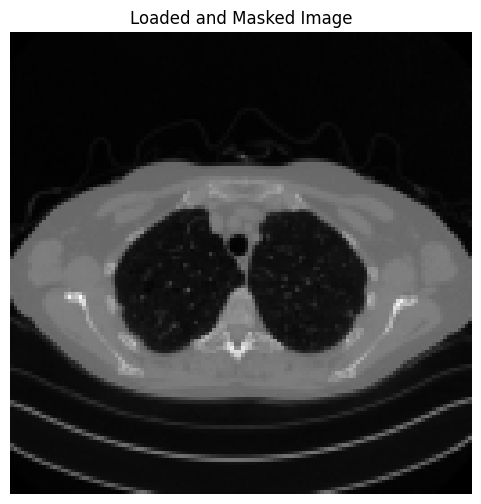

In [3]:
image_size = 128

original_image = load_image_file("./../../data/test/C081/0.png", size=image_size)
#original_image = circular_mask(original_image)

# Display the image (optional)
plt.figure(figsize=(6, 6))
plt.imshow(original_image, cmap='gray')
plt.title('Loaded and Masked Image')
plt.axis('off')
plt.show()

#original_image = load_phantom_image(size=image_size)
#original_image = circular_mask(original_image)
lambda_tv_ista = 0.05 # This value is crucial for the TV regularization. It controls the trade-off between data fidelity and smoothness.
n_iterations_ista = 100
num_angles = 30
noise_level = 0.01
geometries = [(-30, 30), (-15, 15)]
noise_flags = [False, True]
zoom_coords = (slice(40, 80), slice(40, 80))

## Section 5: Evaluate results

Description: This section iterates through different CT geometries (angle ranges) and noise conditions. For each combination, it generates a sinogram, performs reconstructions using FBP and TV-ISTA, calculates image quality metrics (Relative Error, PSNR, SSIM), and displays the original image alongside the FBP and TV-ISTA reconstructions, both full and zoomed views. The resulting plots are saved as PNG files.


Generating plot for angles (-30, 30), noise=False
Iter 20/100 - Data Fidelity: 37341.3114


/Users/ma3ti/Documents/Uni/Magistrale/Computational_imaging/TomographicReconstruction/.venv/lib/python3.13/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Iter 40/100 - Data Fidelity: 10372.3095
Iter 60/100 - Data Fidelity: 6739.1979
Iter 80/100 - Data Fidelity: 5147.2093
Iter 100/100 - Data Fidelity: 4201.0124
Saved plot: tv_only_plot_-30to30_noise0.png


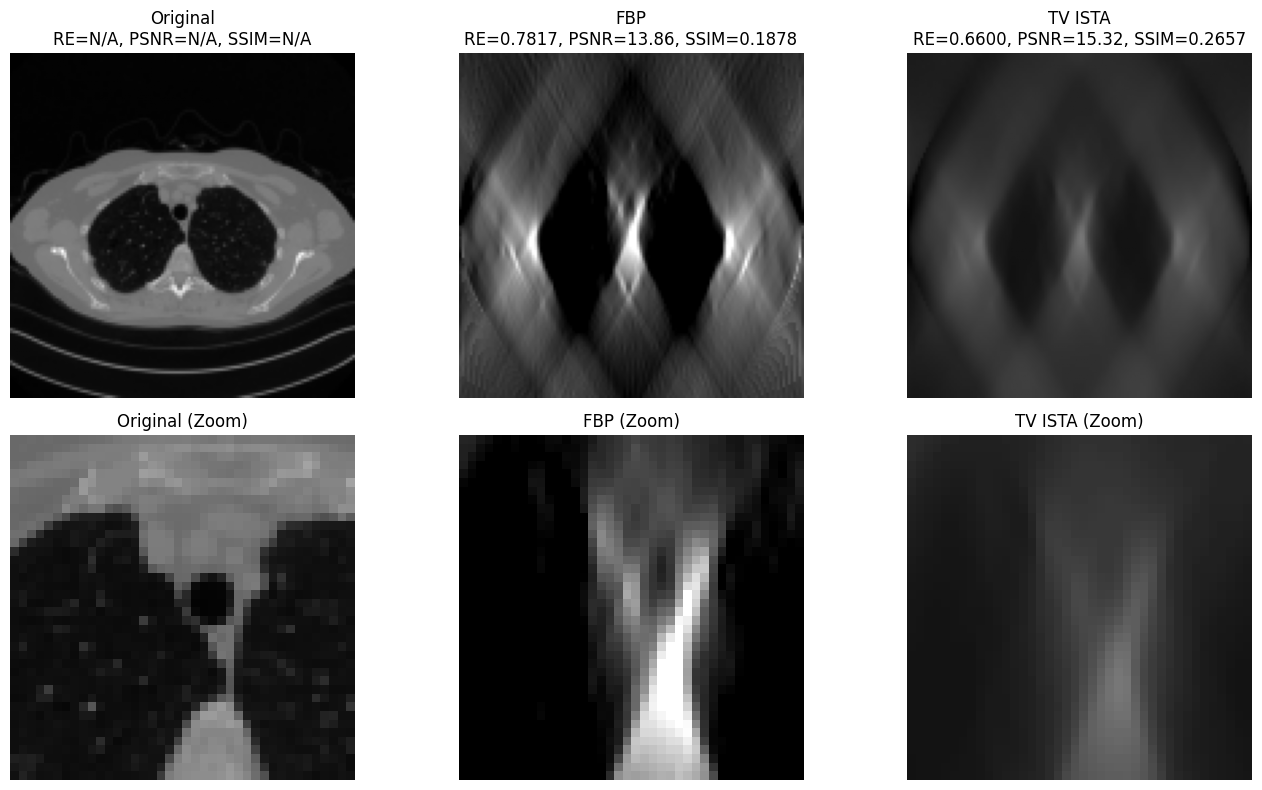


Generating plot for angles (-30, 30), noise=True
Iter 20/100 - Data Fidelity: 37471.7061
Iter 40/100 - Data Fidelity: 10528.2740
Iter 60/100 - Data Fidelity: 6898.6140
Iter 80/100 - Data Fidelity: 5304.9024
Iter 100/100 - Data Fidelity: 4355.5494
Saved plot: tv_only_plot_-30to30_noise1.png


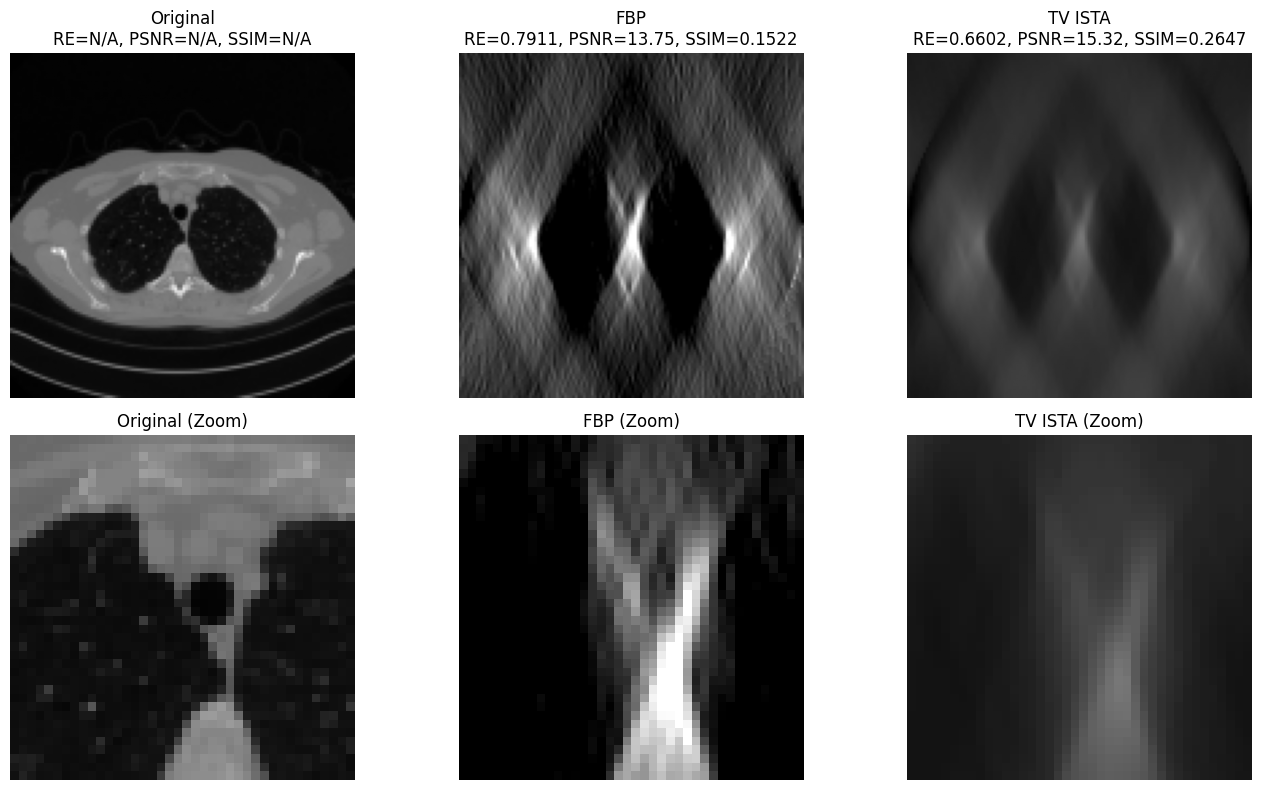


Generating plot for angles (-15, 15), noise=False
Iter 20/100 - Data Fidelity: 23109.8996
Iter 40/100 - Data Fidelity: 3715.6135
Iter 60/100 - Data Fidelity: 2593.9534
Iter 80/100 - Data Fidelity: 2188.5312
Iter 100/100 - Data Fidelity: 1926.0076
Saved plot: tv_only_plot_-15to15_noise0.png


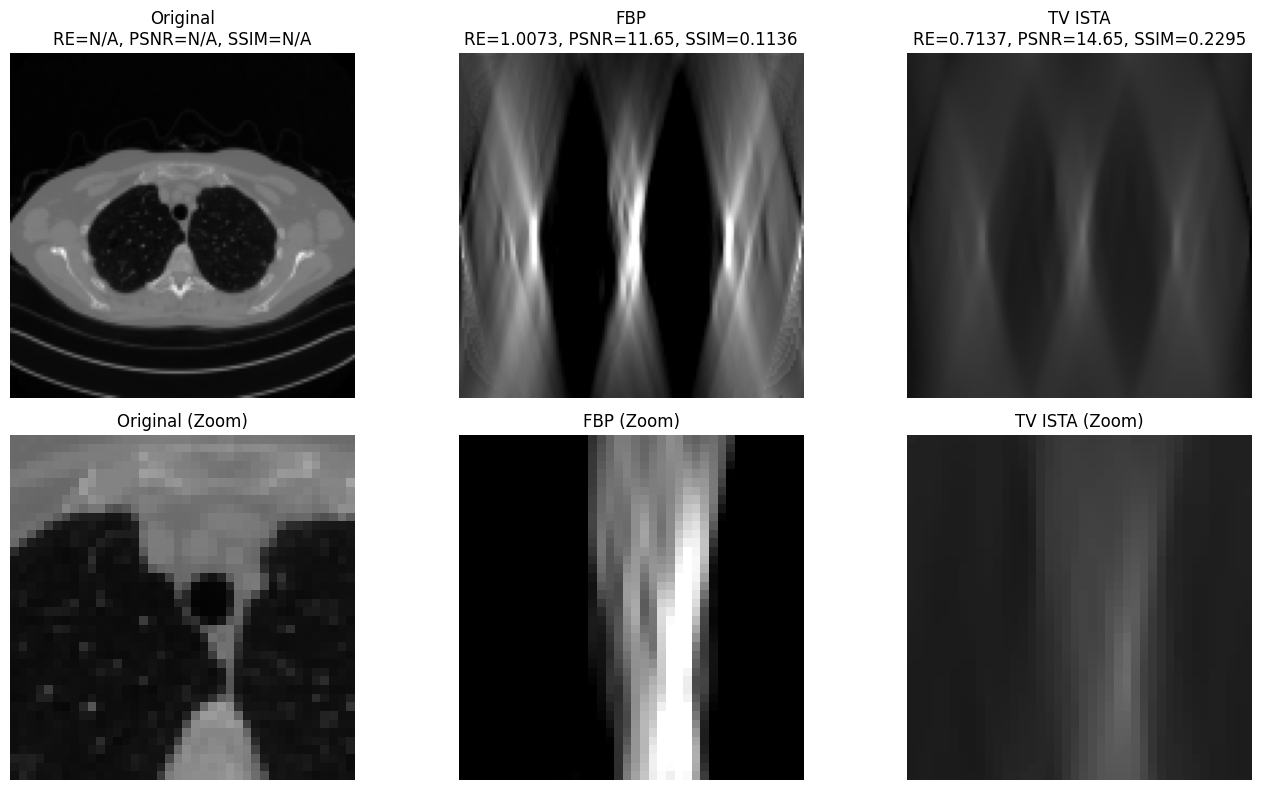


Generating plot for angles (-15, 15), noise=True
Iter 20/100 - Data Fidelity: 23360.7597
Iter 40/100 - Data Fidelity: 3938.9007
Iter 60/100 - Data Fidelity: 2806.5138
Iter 80/100 - Data Fidelity: 2393.4539
Iter 100/100 - Data Fidelity: 2124.8153
Saved plot: tv_only_plot_-15to15_noise1.png


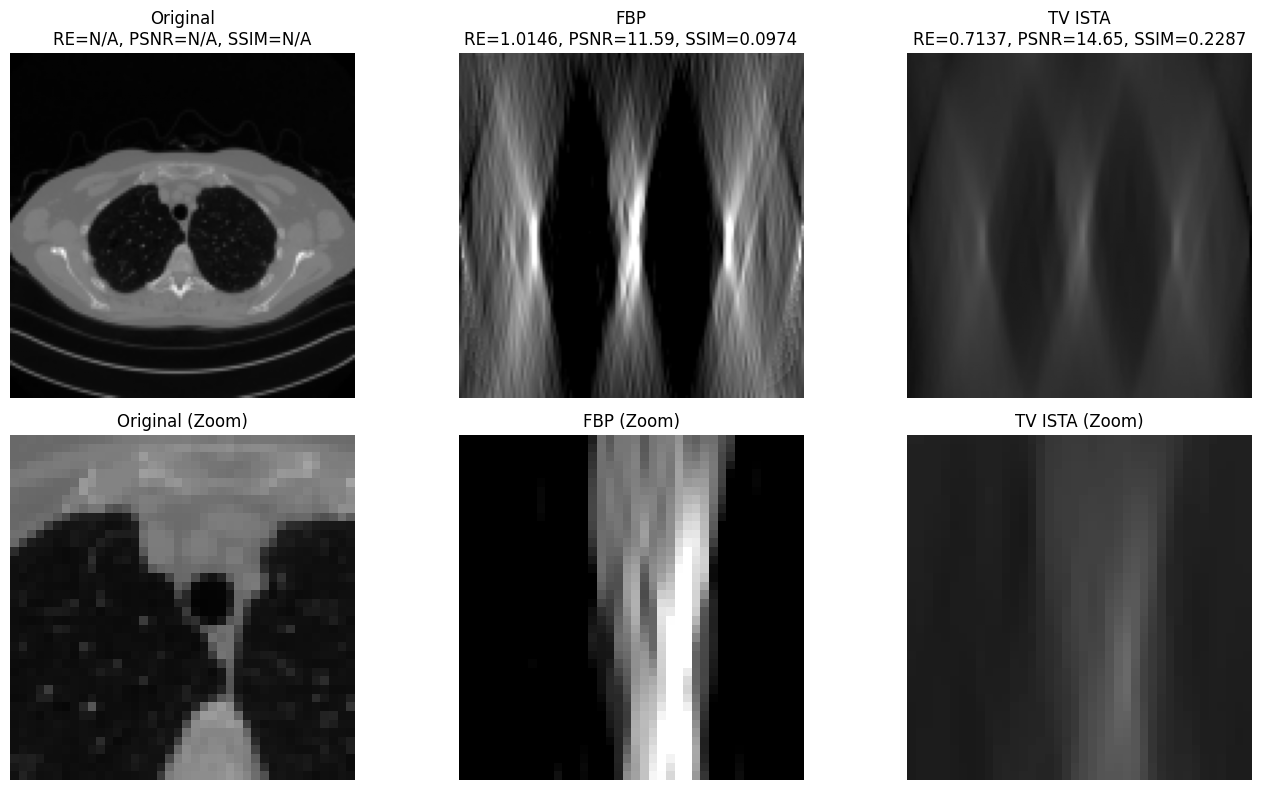

In [4]:
for angle_range in geometries:
    for noise_flag in noise_flags:
        print(f"\nGenerating plot for angles {angle_range}, noise={noise_flag}")

        sinogram, theta = generate_limited_angle_sinogram(
            original_image, num_angles=num_angles, angle_range_deg=angle_range,
            add_noise=noise_flag, noise_level=noise_level)

        fbp = iradon(sinogram, theta=theta, output_size=image_size, filter_name='ramp', circle=False)
        fbp = np.clip(fbp, 0, 1)

        ista = tv_reconstruct_ista(sinogram, theta, lamda_tv=lambda_tv_ista, n_iter=n_iterations_ista,
                                   image_shape=original_image.shape, initial_reconstruction=np.zeros_like(original_image))
        ista = np.clip(ista, 0, 1)

        imgs = [original_image, fbp, ista]
        titles = ["Original", "FBP", "TV ISTA"]
        metrics = [
            ("N/A", "N/A", "N/A"),
            (f"{relative_error(original_image, fbp):.4f}", f"{psnr(original_image, fbp, data_range=1.0):.2f}", f"{ssim(original_image, fbp, data_range=1.0, channel_axis=None):.4f}"),
            (f"{relative_error(original_image, ista):.4f}", f"{psnr(original_image, ista, data_range=1.0):.2f}", f"{ssim(original_image, ista, data_range=1.0, channel_axis=None):.4f}")
        ]

        fig, axs = plt.subplots(2, 3, figsize=(14, 8))
        for i, (ax_full, ax_zoom, img, title, (re, psn, ssi)) in enumerate(zip(axs[0], axs[1], imgs, titles, metrics)):
            ax_full.imshow(img, cmap='gray', vmin=0, vmax=1)
            ax_full.set_title(f"{title}\nRE={re}, PSNR={psn}, SSIM={ssi}")
            ax_full.axis('off')

            ax_zoom.imshow(img[zoom_coords], cmap='gray', vmin=0, vmax=1)
            ax_zoom.set_title(f"{title} (Zoom)")
            ax_zoom.axis('off')

        plt.tight_layout()
        filename = f"tv_only_plot_{angle_range[0]}to{angle_range[1]}_noise{int(noise_flag)}.png"
        plt.savefig(filename, dpi=150)
        print(f"Saved plot: {filename}")
        plt.show()
